**This File**

This file is aimed to contain code used to generate any figures used in the final paper, so that all styles can be updated simultaneously. This file should be kept clean with only plot creation code and no data generation so that the whole file may be run to generate all plots in a timely manner.

In [2]:
%run gradients
%run representation_analysis
%run read_experiments
%run trajectories

from scipy import stats

pplt.rc.reset()



def add_abc_to_subaxes(ax, text='A.', left=0, top=1.05):
    '''
    Add ABC type labels to specific subaxes similar to those
    from proplot
    
    Note that if creating a single ax as in fig, ax = pplt.subplots()
    the ax to pass in is add_abc_to_subaxes(ax[0]) since it works
    with subaxes specifically
    '''
    abc_kw = pplt.rc.fill(
        {
            'size': 'abc.size',
            'weight': 'abc.weight',
            'color': 'abc.color',
            'family': 'font.family',
        },
        context=True
    )
    border_kw = pplt.rc.fill(
        {
            'border': 'abc.border',
            'borderwidth': 'abc.borderwidth',
            'bbox': 'abc.bbox',
            'bboxpad': 'abc.bboxpad',
            'bboxcolor': 'abc.bboxcolor',
            'bboxstyle': 'abc.bboxstyle',
            'bboxalpha': 'abc.bboxalpha',
        },
        context=True,
    )
    kw = {'zorder': 3.5, 'transform': ax.transAxes}
    
    ax.text(left, top, text, **abc_kw, **border_kw, **kw)



# Batch Size Effects

Plot demonstrating how batch size effects learning curves

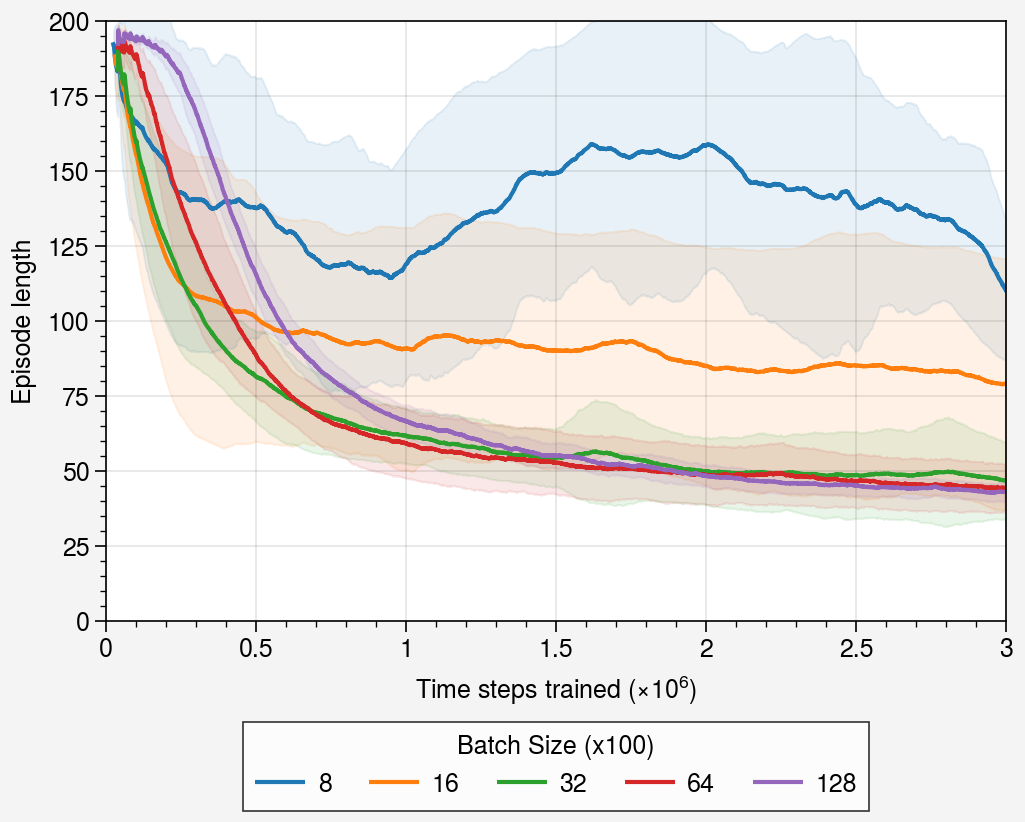

In [109]:
folder = 'nav_pdistal_batchaux'
batch_sizes = [8, 16, 32, 64, 128]
fig, ax = pplt.subplots(refheight=3, refaspect=1.5)

hs = []
for i, batch in enumerate(batch_sizes):
    exp = f'{folder}/nav_pdistal_batch{batch}auxnone'
    h = average_runs(exp, 'length', ax=ax, label=f'Batch {batch}', cloud_by='std', 
                     ignore_first=100, color=rgb_colors[i], ewm=0.001, div_x_by_mil=True)
    hs.append(h)
    
fig.legend(hs, loc='b', labels=[f'{batch}' for batch in batch_sizes], title='Batch Size (x100)', ncol=5)
ax.format(xlabel=r'Time steps trained ($\times 10^6$)', ylabel='Episode length', ylim=[0, 200],
         xlim=[0, 3])

plt.savefig('plots/paper/1_batchsize_effects')

## Network Width Effects

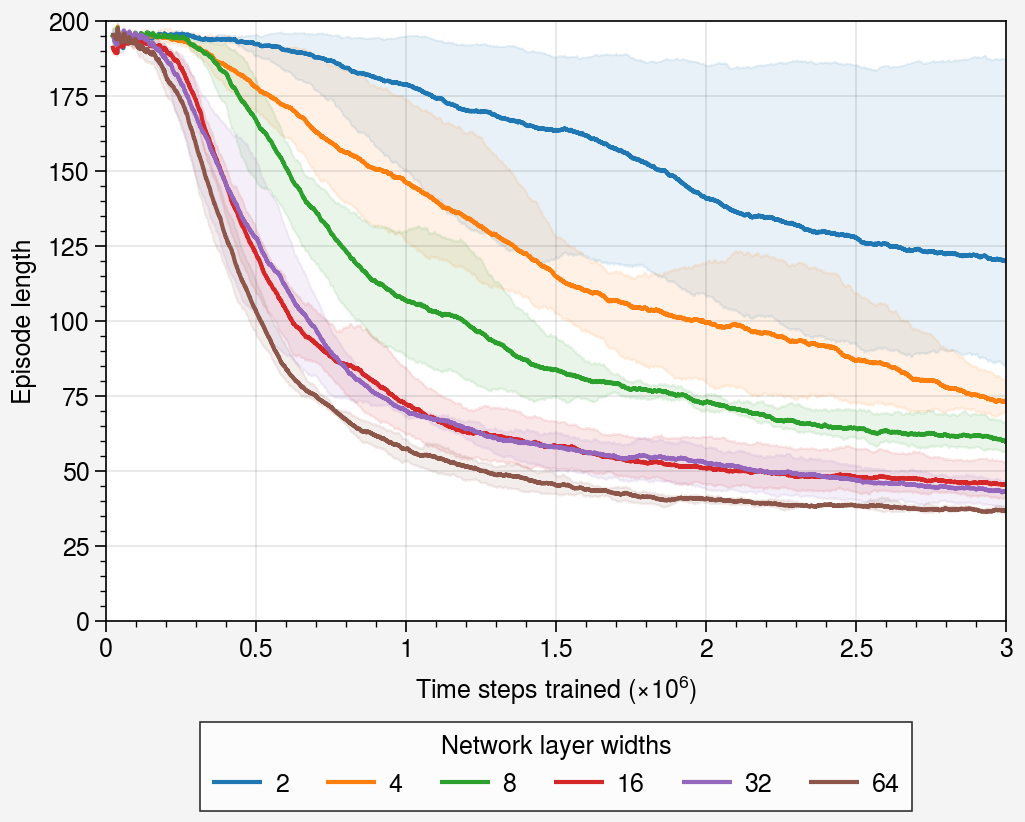

In [108]:
widths = [2, 4, 8, 16, 32, 64]
distal_exp_names = [f'nav_poster_netstructure/nav_pdistal_width{width}batch200' for width in widths]
fig, ax = pplt.subplots(refheight=3, refaspect=1.5)

lines = []
for i in range(len(widths)):
    line = average_runs(distal_exp_names[i], 'length', ax=ax, ignore_first=100, ewm=0.001,
                 div_x_by_mil=True, color=rgb_colors[i])
    lines.append(line[0])
    
ax.format(
    xlabel=r'Time steps trained ($\times 10^6$)', 
    ylabel='Episode length',
    # title='Training Curves for Different Network Widths on Poster Environments',
    ylim=[0, 200],
    xlim=[0, 3]
)
fig.legend(lines, title='Network layer widths', labels=[str(w) for w in widths], loc='b', ncol=len(widths))
plt.savefig('plots/paper/1_1_layerwidth_effects')

# Environment Demonstrations

Plots showing what the environment actually looks like

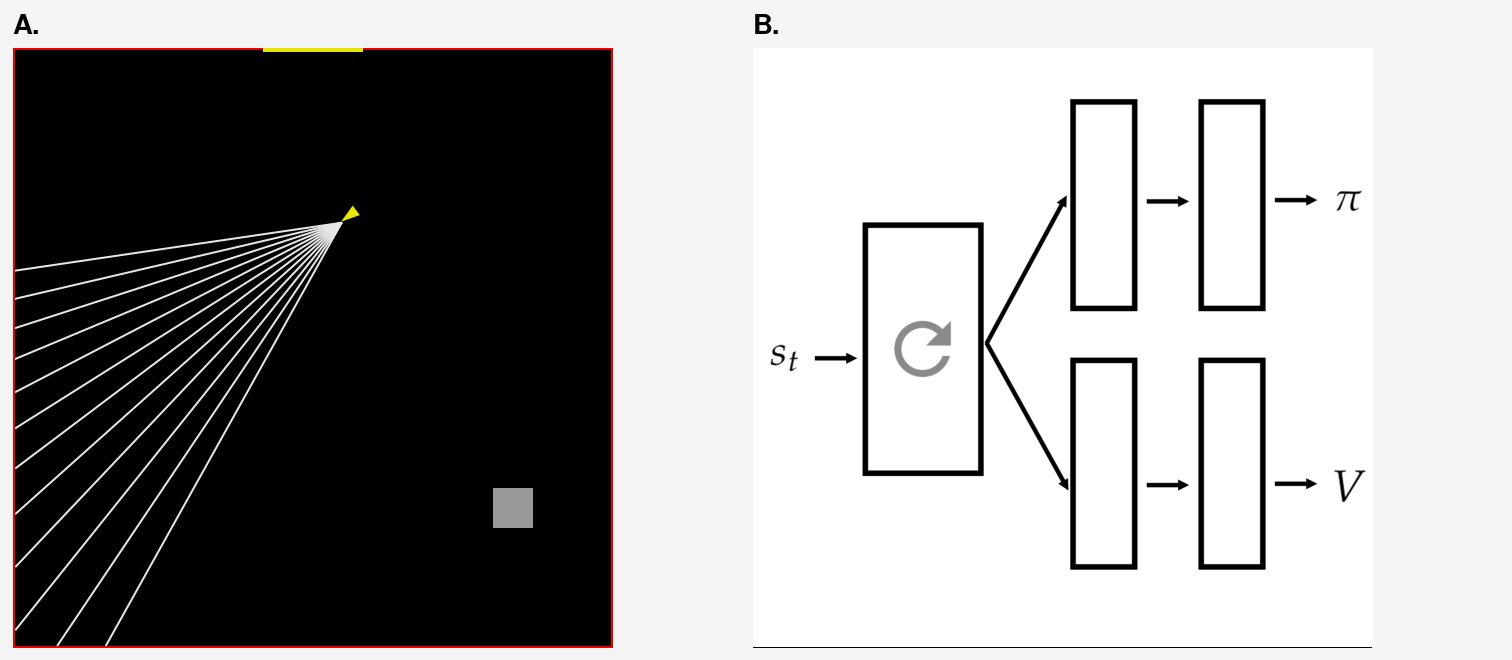

In [85]:
import matplotlib.image as mpimg

env_kwargs = pickle.load(open('../trained_models/ppo/nav_pdistal_batchaux/nav_pdistal_batch16auxnone_env', 'rb'))

pplt.rc.update({
    'axes.spines.bottom': False,
    'axes.spines.top': False,
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.facecolor': 'black',
    'axes.grid': False
})

fig, ax = pplt.subplots(ncols=2, wratios=(2, 3), refheight=3, sharex=False, sharey=False)

env = gym.make('NavEnv-v0', **env_kwargs)
np.random.seed(0)
env.reset()
env.render('human', ax=ax[0])

ax[1].imshow(mpimg.imread('plots/paper/nn_diagram.png'))
ax[0].format(xlim=[0, 300], ylim=[0, 300])
ax.format(abc='A.', abcloc='l')


fig.savefig('plots/paper/2_mwm_poster_env')

pplt.rc.reset()


# Auxiliary Task Performances

## Numerical Experiments

### Performance Significance

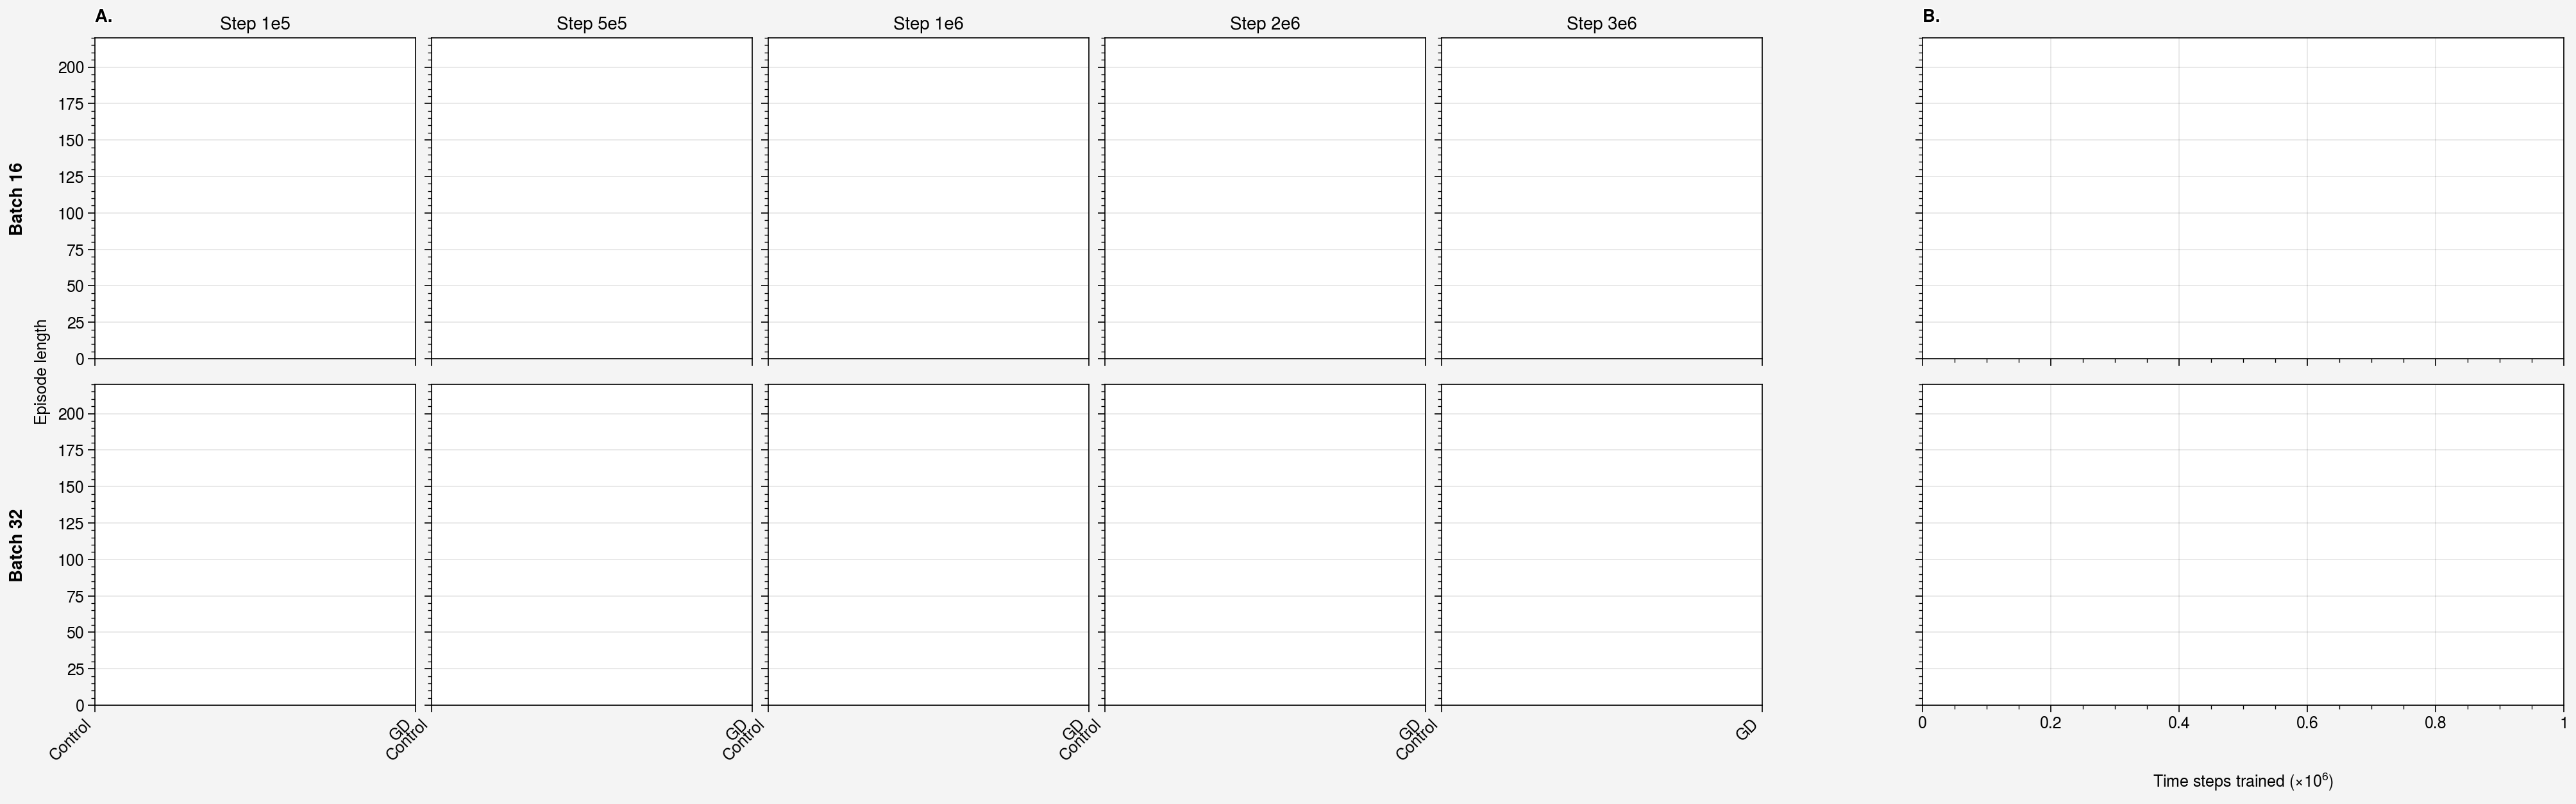

In [74]:
# Example formatting code

timepoint_labels = ['1e5', '5e5', '1e6', '2e6', '3e6']


fig, ax = pplt.subplots(nrows=2, ncols=6, 
                        wratios=(1, 1, 1, 1, 1, 2), wspace=(1, 1, 1, 1, 10),
                        spanx=1)

ax.format(ylim=[0, 200])
ax[:, :-1].format(xlocator=range(6))

add_abc_to_subaxes(ax[0, 0], 'A.')
add_abc_to_subaxes(ax[0, 5], 'B.')

ax[:, -1].format(xlabel=r'Time steps trained ($\times 10^6$)', ylabel='Episode length',
         ylim=[0, 220])
ax[0, :-1].format(title=[f'Step {step}' for step in timepoint_labels])
ax[:, :-1].format(xticklabels=aux_labels, xrotation=45,
          leftlabels=[f'Batch {batch}' for batch in batch_sizes],
          ylim=[0, 220])

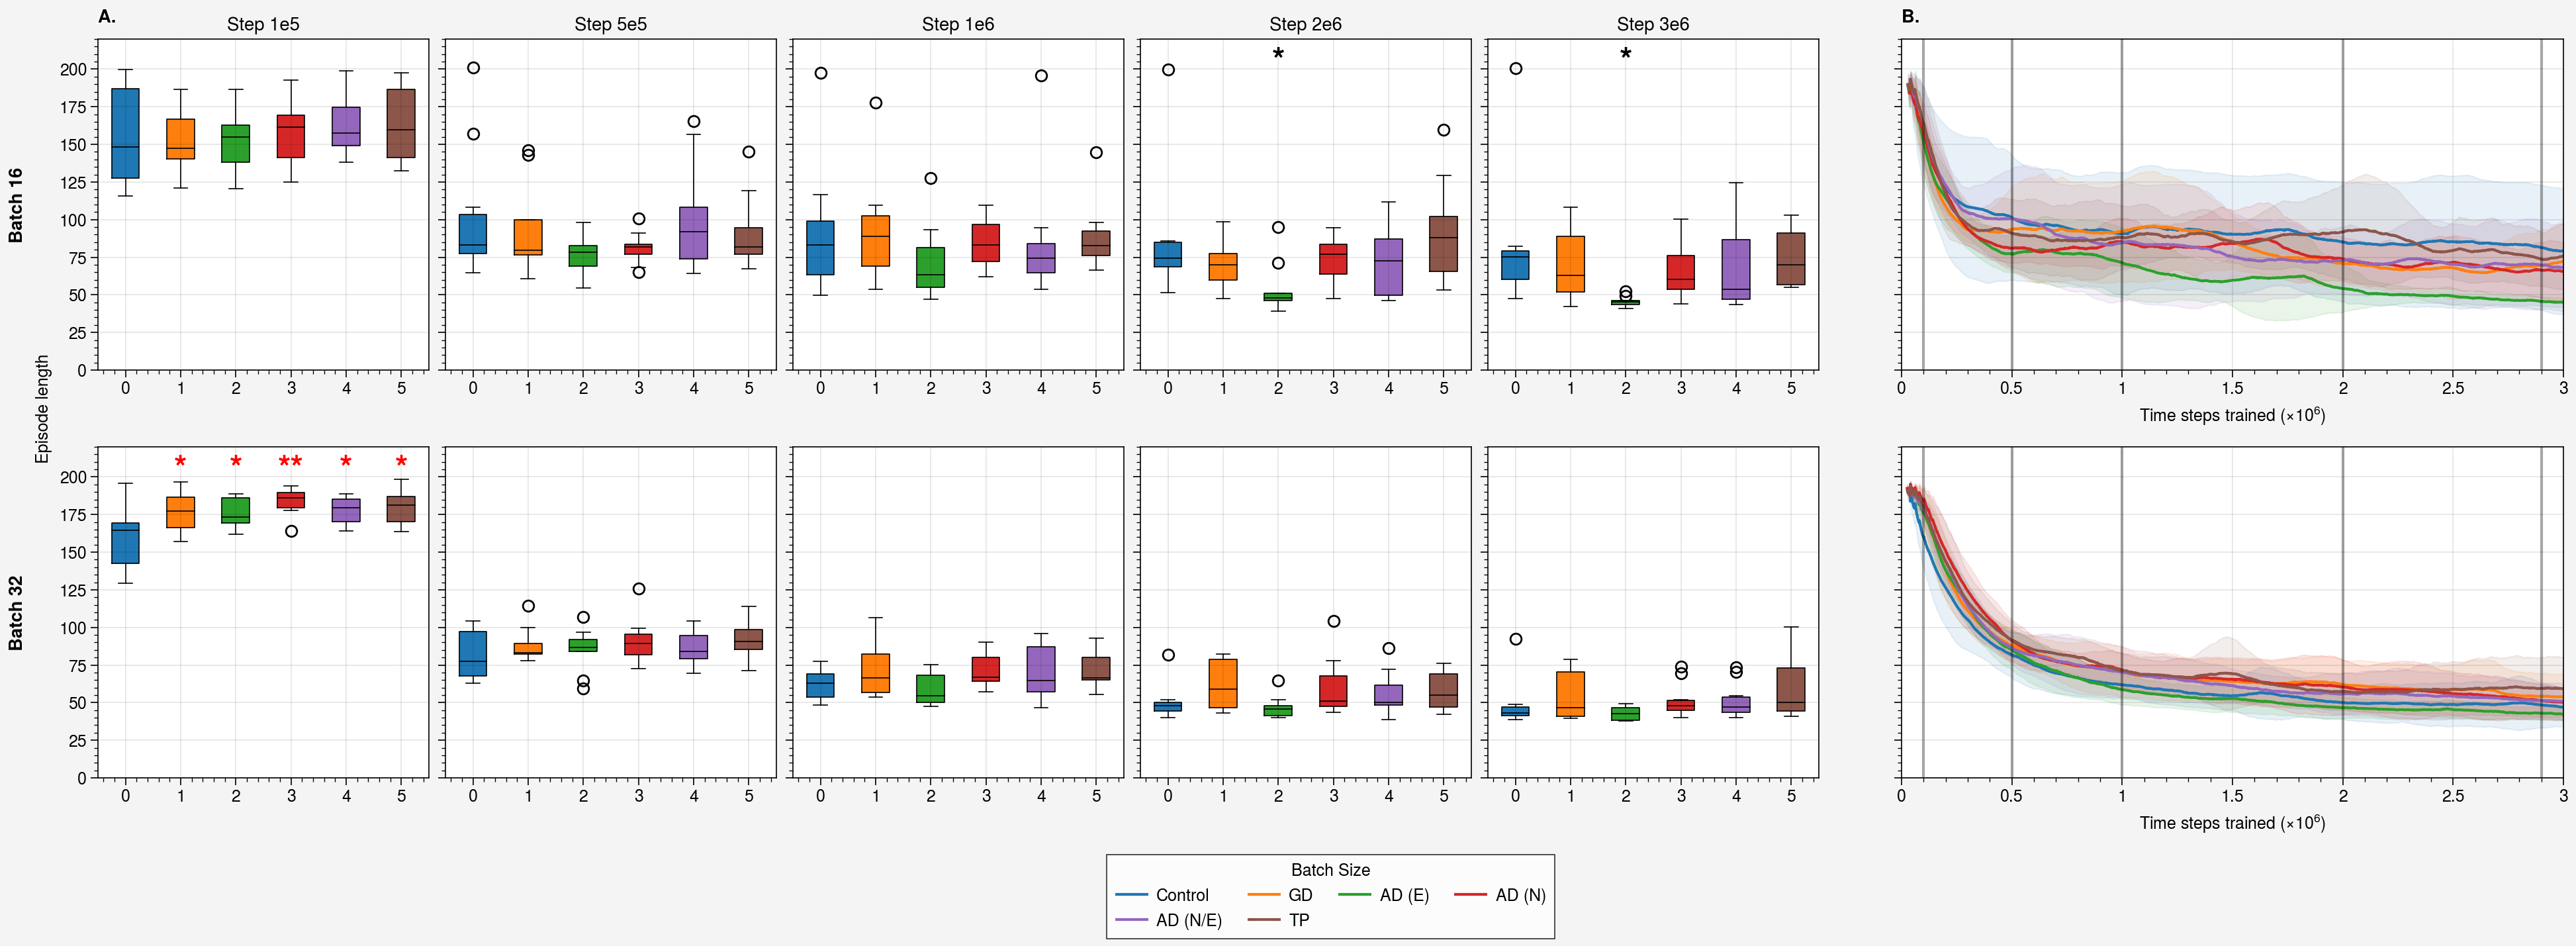

In [112]:
aux_tasks = ['none', 'goaldist', 'wall0', 'wall1', 'wall01', 'terminal']
aux_labels = ['Control', 'GD', 'AD (E)', 'AD (N)', 'AD (N/E)', 'TP']
batch_sizes = [16, 32]
timepoints = [100000, 500000, 1000000, 2000000, 2900000]
timepoint_labels = ['1e5', '5e5', '1e6', '2e6', '3e6']


fig, ax = pplt.subplots(nrows=len(batch_sizes), ncols=len(timepoints)+1, 
                        wratios=(1, 1, 1, 1, 1, 2), wspace=(1, 1, 1, 1, 5),
                        sharex=False)

# Collect time points data for making box plots
y_timepoints = {}
for i, batch in enumerate(batch_sizes):
    y_timepoints[batch] = defaultdict(list)
    
    for aux in aux_tasks:
        if aux == 'none':
            exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
        else:
            exp_name = f'nav_pdistal_batchauxcoef1/nav_pdistal_batch{batch}aux{aux}coef1'
            
        xs, ys, start_x, start_y = average_runs(exp_name, 'length', ignore_first=100, ewm=0.001, ret=True)
        
        for n, timepoint in enumerate(timepoints):
            idx = np.argwhere(xs > timepoint)[0][0]
            y_timepoints[batch][timepoint].append(list(ys[:, idx]))

            
# Plot boxplots with significance stars

for i, batch in enumerate(batch_sizes):
    for j, timepoint in enumerate(timepoints):
        y_samples = y_timepoints[batch][timepoint]
        
        for n in range(1, 6):
            pvalue = stats.ttest_ind(y_samples[0], y_samples[n]).pvalue
            star = ''
            if pvalue < 0.05:
                star = '*'
            if pvalue < 0.01:
                star = '**'
            if pvalue < 0.001:
                star = '***'

            if np.mean(y_samples[0]) < np.mean(y_samples[n]):
                c = 'red'
            else:
                c = 'black'

            if len(star) > 0:
                ax[i, j].text(n, 215, star, c=c, ha='center', va='top', size=18, fontweight='bold')
        
        ax[i, j].boxplot(np.array(y_samples).T, fill=True,
          cycle=[list(rgb_colors[i]) for i in range(6)])
            


# Plot learning curves

for i, batch in enumerate(batch_sizes):
    lines = []
    for n, aux in enumerate(aux_tasks):
        if aux == 'none':
            exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
        else:
            exp_name = f'nav_pdistal_batchauxcoef1/nav_pdistal_batch{batch}aux{aux}coef1'
            
        # exp_name = f'nav_pdistal_auxcat/nav_pdistal_width{width}aux{aux}'

        line = average_runs(exp_name, 'length', ax=ax[i, -1], ignore_first=100, ewm=0.001, color=rgb_colors[n],
                           cloud_by='std', div_x_by_mil=True)
        lines.append(line[0])

# Add time point lines to learning curves

timepoints = np.array([100000, 500000, 1000000, 2000000, 2900000])/1000000
for timepoint in timepoints:
    for i in range(2):
        ax[i, -1].plot([timepoint, timepoint], [-10, 230], 'black', alpha=0.35)
        
        

#Formatting 

add_abc_to_subaxes(ax[0, 0], 'A.')
add_abc_to_subaxes(ax[0, 5], 'B.')

ax[:, -1].format(xlabel=r'Time steps trained ($\times 10^6$)', ylabel='Episode length',
         ylim=[0, 220], xlim=[0, 3])
ax[0, :-1].format(title=[f'Step {step}' for step in timepoint_labels])

## Include x labels on box plots
# ax[:, :-1].format(xticklabels=aux_labels, xrotation=45,
#           leftlabels=[f'Batcch {batch}' for batch in batch_sizes],
#           ylim=[0, 220])
# No x labels for box plots
ax[:, :-1].format(leftlabels=[f'Batch {batch}' for batch in batch_sizes],
          ylim=[0, 220])

fig.legend(lines, loc='b', ncols=4, labels=aux_labels, 
           title='Batch Size')

fig.savefig('plots/paper/3_1_1_numerical_learning_performance')


### Losses

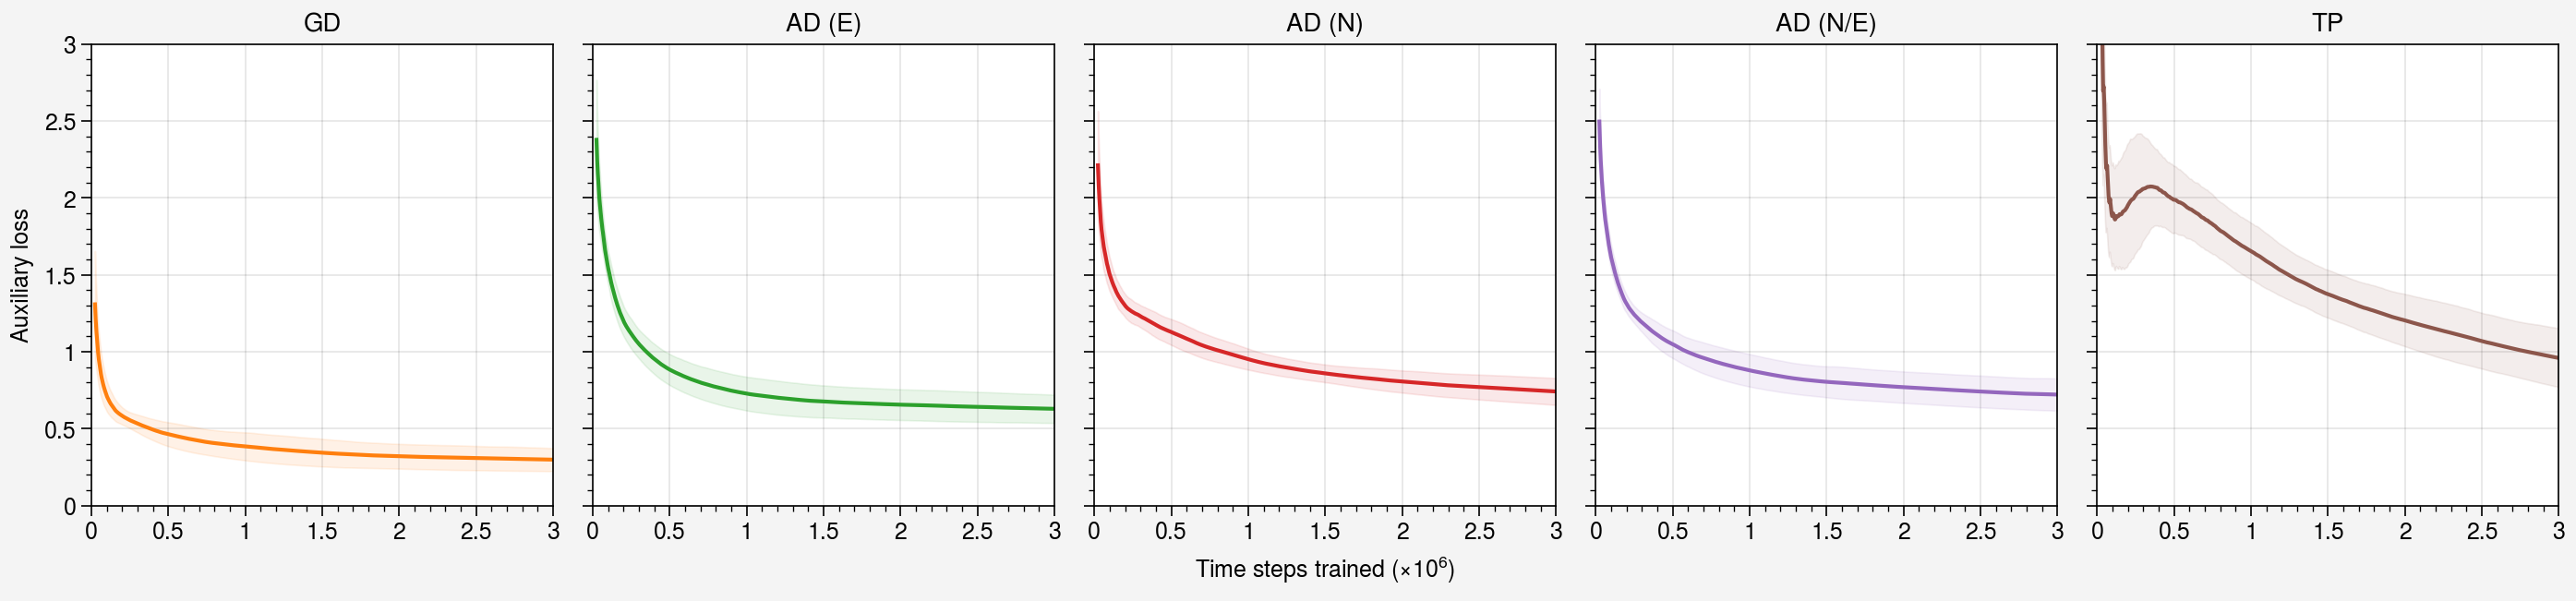

In [111]:
aux_tasks = ['goaldist', 'wall0', 'wall1', 'wall01', 'terminal']
aux_labels = ['GD', 'AD (E)', 'AD (N)', 'AD (N/E)', 'TP']

fig, ax = pplt.subplots(ncols=len(aux_tasks))

lines = []
for i, aux in enumerate(aux_tasks):
    exp_name = f'nav_pdistal_batchauxcoef1/nav_pdistal_batch32aux{aux}coef1'
    line = average_runs(exp_name, 'aux_loss', ax=ax[i], ignore_first=100, ewm=0.001, 
                        color=rgb_colors[i+1], cloud_by='std', div_x_by_mil=True)
    
    lines.append(line[0])

    # # Add batch 16 as dotted line
    # exp_name = f'nav_pdistal_batchauxcoef1/nav_pdistal_batch16aux{aux}coef1'
    # line = average_runs(exp_name, 'aux_loss', ax=ax[i], ignore_first=100, ewm=0.001, color=rgb_colors[i],
    #                    cloud_by='std', div_x_by_mil=True, ls=(0, (5, 5)), cloud_alpha=0)
    
ax.format(title=aux_labels,
         xlabel=r'Time steps trained ($\times 10^6$)', ylabel='Auxiliary loss', ylim=[0, 3],
         xlim=[0, 3])

fig.savefig('plots/paper/3_1_2_numerical_aux_losses')


## Categorical Auxiliary Tasks

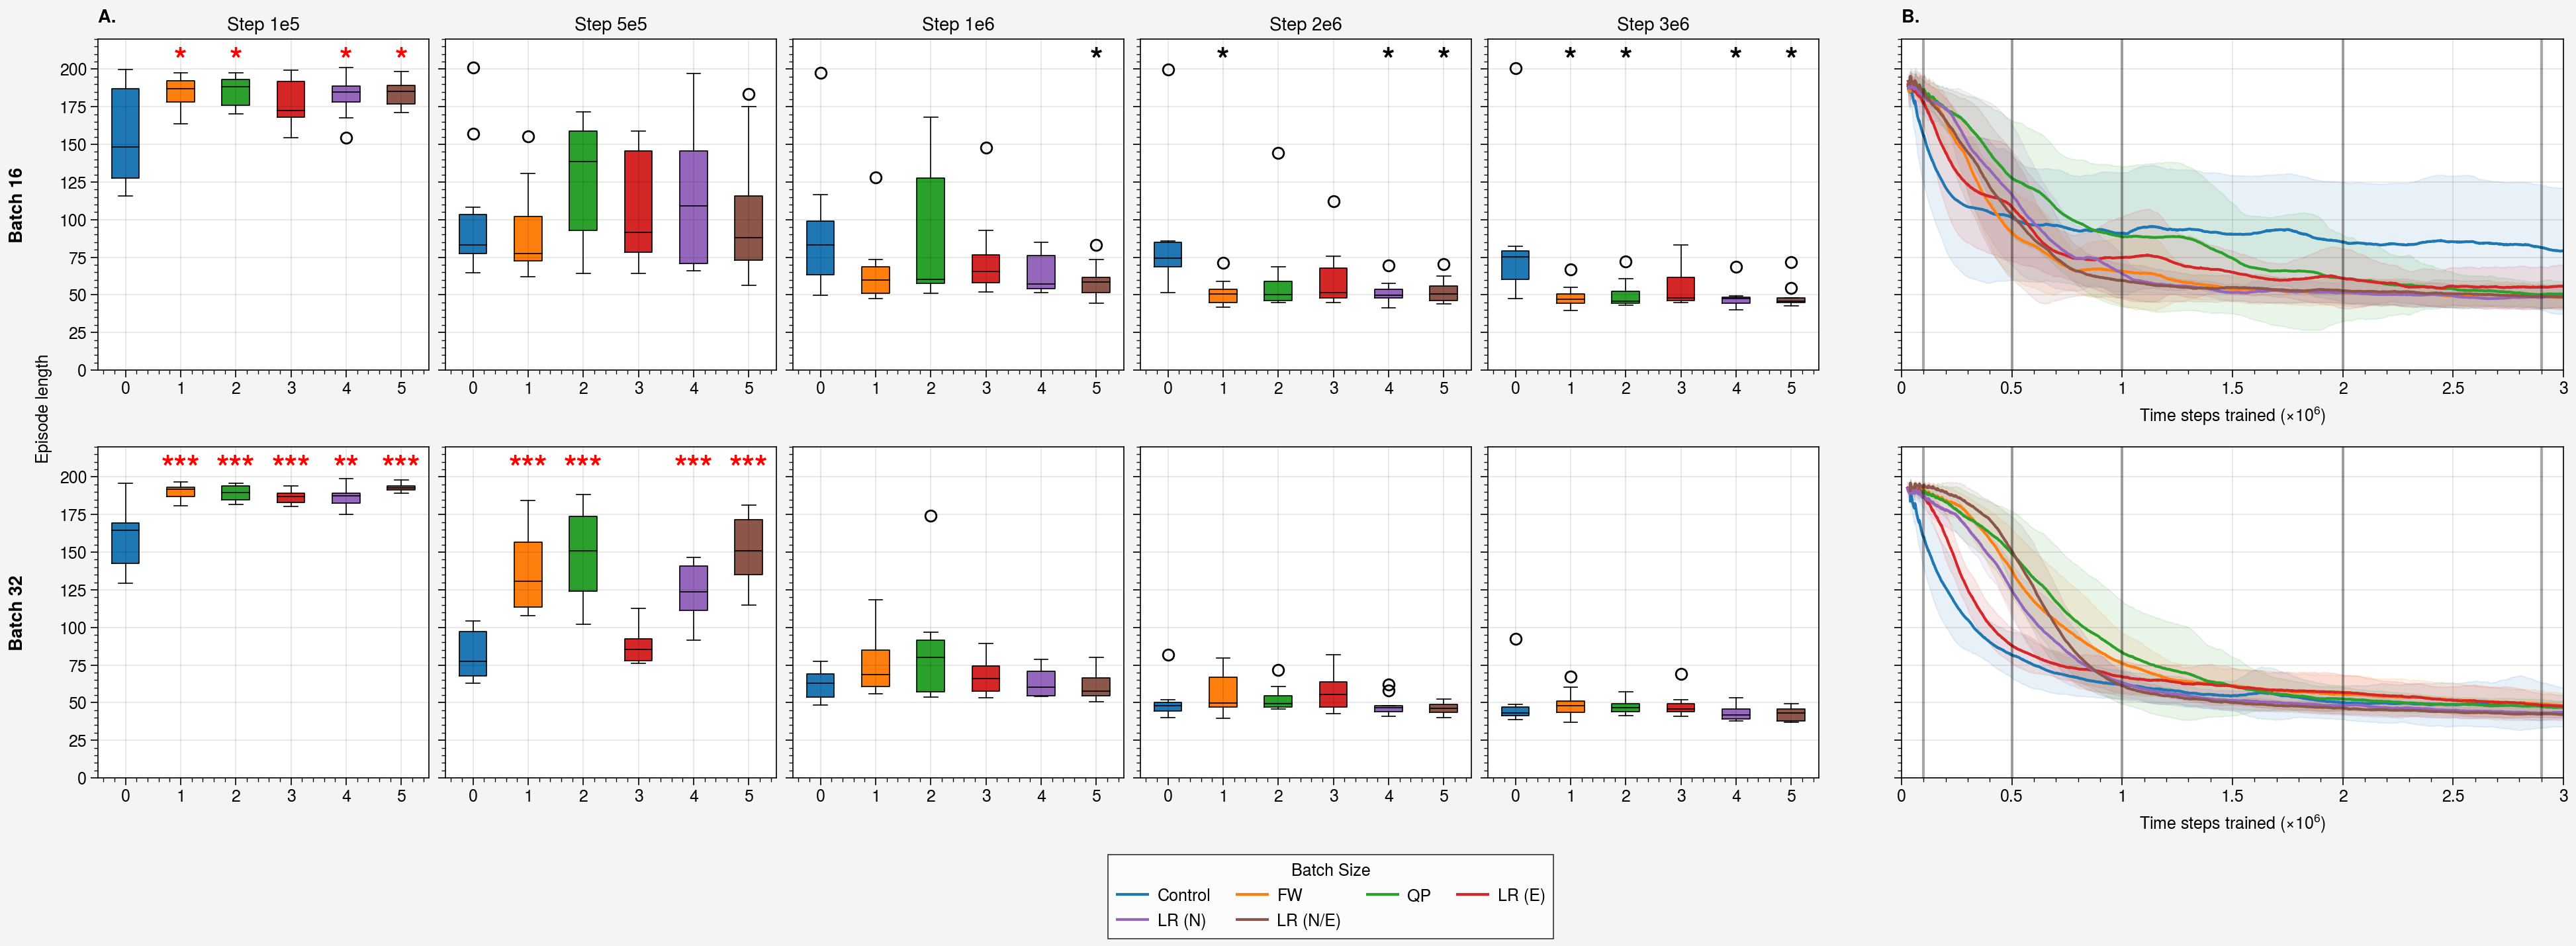

In [7]:
aux_tasks = ['none', 'catfacewall', 'catquad', 'catwall0', 'catwall1', 'catwall01']
aux_labels = ['Control', 'FW', 'QP', 'LR (E)', 'LR (N)', 'LR (N/E)']
batch_sizes = [16, 32]
timepoints = [100000, 500000, 1000000, 2000000, 2900000]
timepoint_labels = ['1e5', '5e5', '1e6', '2e6', '3e6']


fig, ax = pplt.subplots(nrows=len(batch_sizes), ncols=len(timepoints)+1, 
                        wratios=(1, 1, 1, 1, 1, 2), wspace=(1, 1, 1, 1, 5),
                        sharex=False)

# Collect time points data for making box plots
y_timepoints = {}
for i, batch in enumerate(batch_sizes):
    y_timepoints[batch] = defaultdict(list)
    
    for aux in aux_tasks:
        if aux == 'none':
            exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
        else:
            exp_name = f'nav_pdistal_auxcatcoef1/nav_pdistal_batch{batch}aux{aux}coef1'
            
        xs, ys, start_x, start_y = average_runs(exp_name, 'length', ignore_first=100, ewm=0.001, ret=True)
        
        for n, timepoint in enumerate(timepoints):
            idx = np.argwhere(xs > timepoint)[0][0]
            y_timepoints[batch][timepoint].append(list(ys[:, idx]))

            
# Plot boxplots with significance stars

for i, batch in enumerate(batch_sizes):
    for j, timepoint in enumerate(timepoints):
        y_samples = y_timepoints[batch][timepoint]
        
        for n in range(1, 6):
            pvalue = stats.ttest_ind(y_samples[0], y_samples[n]).pvalue
            star = ''
            if pvalue < 0.05:
                star = '*'
            if pvalue < 0.01:
                star = '**'
            if pvalue < 0.001:
                star = '***'

            if np.mean(y_samples[0]) < np.mean(y_samples[n]):
                c = 'red'
            else:
                c = 'black'

            if len(star) > 0:
                ax[i, j].text(n, 215, star, c=c, ha='center', va='top', size=18, fontweight='bold')
        
        ax[i, j].boxplot(np.array(y_samples).T, fill=True,
          cycle=[list(rgb_colors[i]) for i in range(6)])
            


# Plot learning curves

for i, batch in enumerate(batch_sizes):
    lines = []
    for n, aux in enumerate(aux_tasks):
        if aux == 'none':
            exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
        else:
            exp_name = f'nav_pdistal_auxcatcoef1/nav_pdistal_batch{batch}aux{aux}coef1'
            
        # exp_name = f'nav_pdistal_auxcat/nav_pdistal_width{width}aux{aux}'

        line = average_runs(exp_name, 'length', ax=ax[i, -1], ignore_first=100, ewm=0.001, color=rgb_colors[n],
                           cloud_by='std', div_x_by_mil=True)
        lines.append(line[0])

# Add time point lines to learning curves

timepoints = np.array([100000, 500000, 1000000, 2000000, 2900000])/1000000
for timepoint in timepoints:
    for i in range(2):
        ax[i, -1].plot([timepoint, timepoint], [-10, 230], 'black', alpha=0.35)
        
        

#Formatting 

add_abc_to_subaxes(ax[0, 0], 'A.')
add_abc_to_subaxes(ax[0, 5], 'B.')

ax[:, -1].format(xlabel=r'Time steps trained ($\times 10^6$)', ylabel='Episode length',
         ylim=[0, 220], xlim=[0, 3])
ax[0, :-1].format(title=[f'Step {step}' for step in timepoint_labels])

## Include x labels on box plots
# ax[:, :-1].format(xticklabels=aux_labels, xrotation=45,
#           leftlabels=[f'Batcch {batch}' for batch in batch_sizes],
#           ylim=[0, 220])
# No x labels for box plots
ax[:, :-1].format(leftlabels=[f'Batch {batch}' for batch in batch_sizes],
          ylim=[0, 220])

fig.legend(lines, loc='b', ncols=4, labels=aux_labels, 
           title='Batch Size')

fig.savefig('plots/paper/3_2_1_categorical_learning_performance')


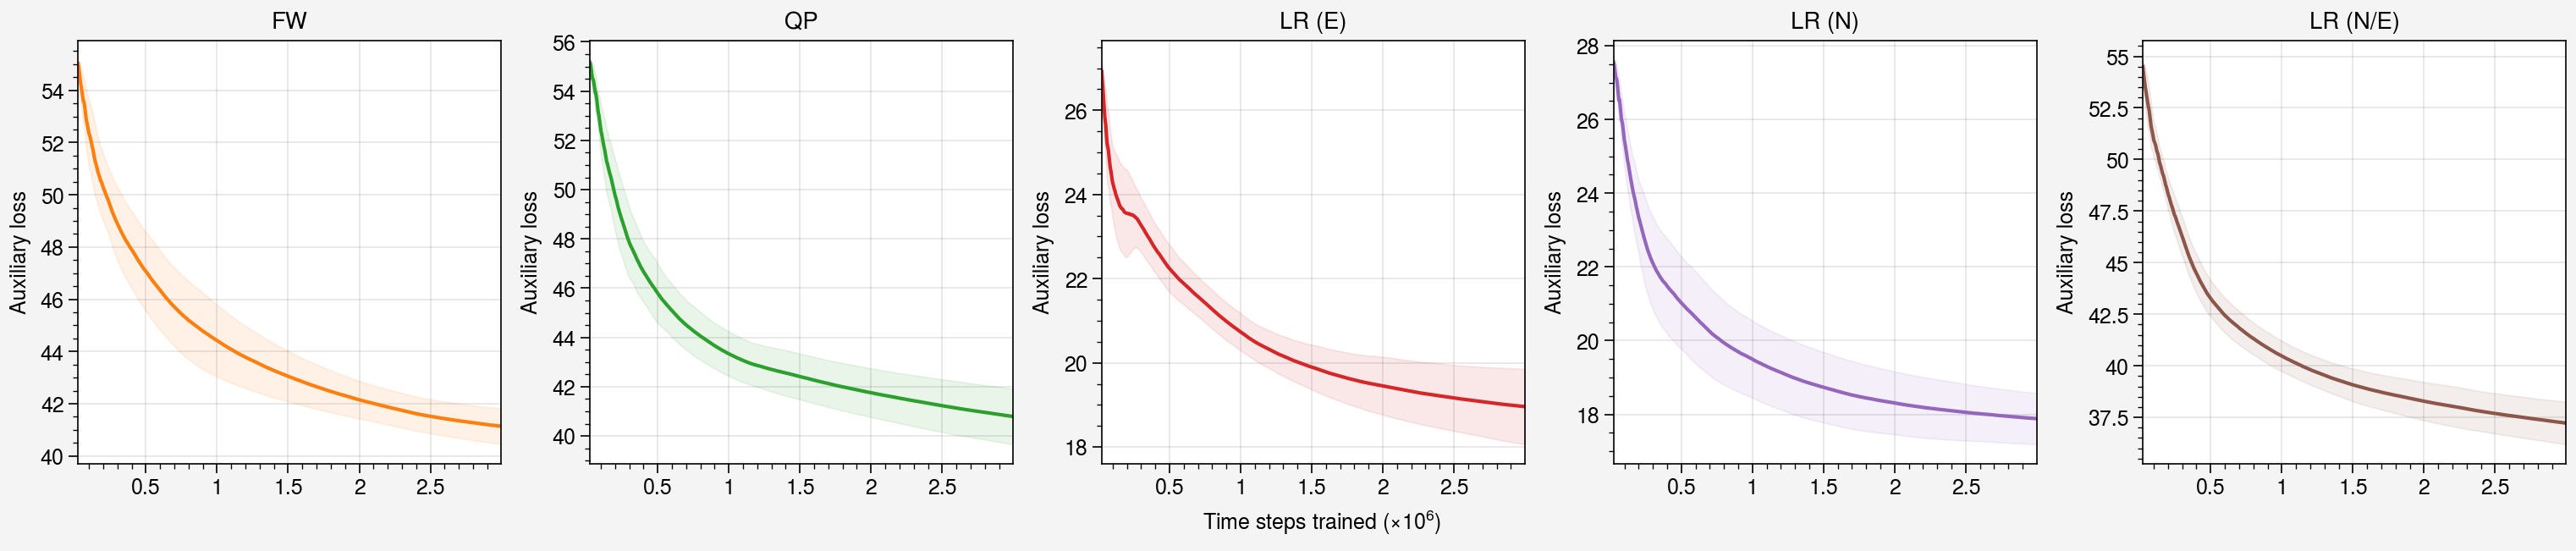

In [8]:
aux_tasks = ['catfacewall', 'catquad', 'catwall0', 'catwall1', 'catwall01']
aux_labels = ['FW', 'QP', 'LR (E)', 'LR (N)', 'LR (N/E)']

batch = 32

fig, ax = pplt.subplots(ncols=len(aux_tasks), sharey=False)

lines = []
for i, aux in enumerate(aux_tasks):
    exp_name = f'nav_pdistal_auxcatcoef1/nav_pdistal_batch{batch}aux{aux}coef1'
    line = average_runs(exp_name, 'aux_loss', ax=ax[i], ignore_first=100, ewm=0.001, 
                        color=rgb_colors[i+1], cloud_by='std', div_x_by_mil=True)
    lines.append(line[0])
    
ax.format(title=aux_labels,
         xlabel=r'Time steps trained ($\times 10^6$)', ylabel='Auxiliary loss')

fig.savefig('plots/paper/3_2_2_categorical_aux_losses')

